# 1. Introduction and Problem Context

*   **Context:**
The goal of this work is to develop a robust classification model for image data using deep learning techniques. The dataset consists of 15,000 images in total, divided into 15 different classes, each representing a different type of vegetable.

*   **General Approach:**
1.   Data Loading:
We use ImageDataGenerator to load and preprocess the 15,000 images in batches, optimizing computational efficiency.

2.   Data Augmentation:
Techniques like rotation, horizontal flips, zooming, shearing, and shifting are applied to enhance dataset variety and prevent overfitting.

3.   Model Architecture:
We fine-tune a pre-trained MobileNetV2 model (ImageNet) by unfreezing the last two layers for better accuracy. The top model consists of just two additional layers, suitable for the dataset's similarity to ImageNet. Dropout and L2 regularization are used to prevent overfitting.

*   **Results:**
The model demonstrates excellent performance on the test set, achieving an **accuracy of 0.9998** and an AUROC of 0.9999. Out of 3,000 test images, only 3 were misclassified, showcasing the model’s robustness and its capacity to make accurate predictions on new, unseen data.

# 2. Loading Packages

In [ ]:
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG16, MobileNetV2, DenseNet121, InceptionV3
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import classification_report,confusion_matrix


from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*weights.*")


In [ ]:
dataset='../input/vegetable-image-dataset/Vegetable Images'

train_dir = os.path.join(dataset,"train")
test_dir = os.path.join(dataset,"validation")
val_dir = os.path.join(dataset,"test")

# 3. EDA

The exploratory data analysis (EDA) revealed important insights into the dataset.
*   First, we confirmed that the images are consistent in size and structure, which is crucial for applying pre-trained models like MobileNet.
*   Additionally, the class distribution is balanced, which simplifies the classification task and removes the need for class weights. Below are the detailed findings:

## 3.1 Image Visualization

Displaying sample images and their labels from each class helps us get a sense of how they look. These samples do not show any signs of mislabeling or other problems.

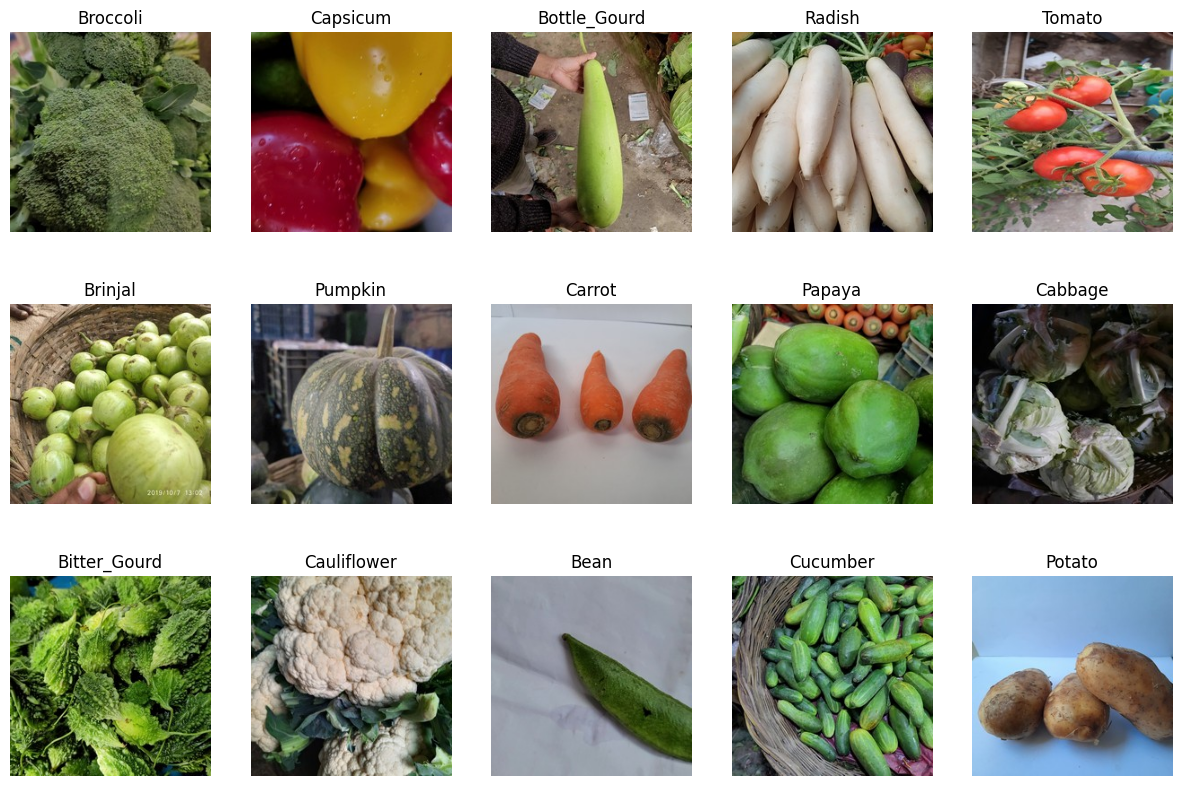

In [ ]:
# Initialize list to store dimensions (height, width, channels)
image_dimensions = []

# Get list of classes
classes = os.listdir(train_dir)

plt.figure(figsize=(15, 10))

# Loop through each class and process the images
for i, class_name in enumerate(classes):
    class_dir = os.path.join(train_dir, class_name)
    images = os.listdir(class_dir)

    # Read the first image in the class directory
    image_path = os.path.join(class_dir, images[0])
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Save height, width, and number of channels
    height, width, channels = image.shape
    image_dimensions.append((height, width, channels))

    # Plot the image
    plt.subplot(3, 5, i+1)
    plt.imshow(image)
    plt.title(class_name)
    plt.axis('off')

plt.show()

## 3.2 Image dimensions

We have randomly checked the image dimensions in each class, and they are consistent: 224x224 with 3 channels (RGB). This means that we can use them without resizing or changing the number of channels, as pre-trained models are usually adapted to this specific size and number of channels.

In [ ]:
df = pd.DataFrame(image_dimensions, columns=["Height", "Width", "Channels"])
df.describe().loc[["min", "mean", "max"]]

,Height,Width,Channels
min,224.0,224.0,3.0
mean,224.0,224.0,3.0
max,224.0,224.0,3.0


## 3.3 Class Distribution

There are 15 different classes in the dataset, all equally distributed. This simplifies the classification task because each class will have the same importance for the model, and we don't need to add class weights during training.

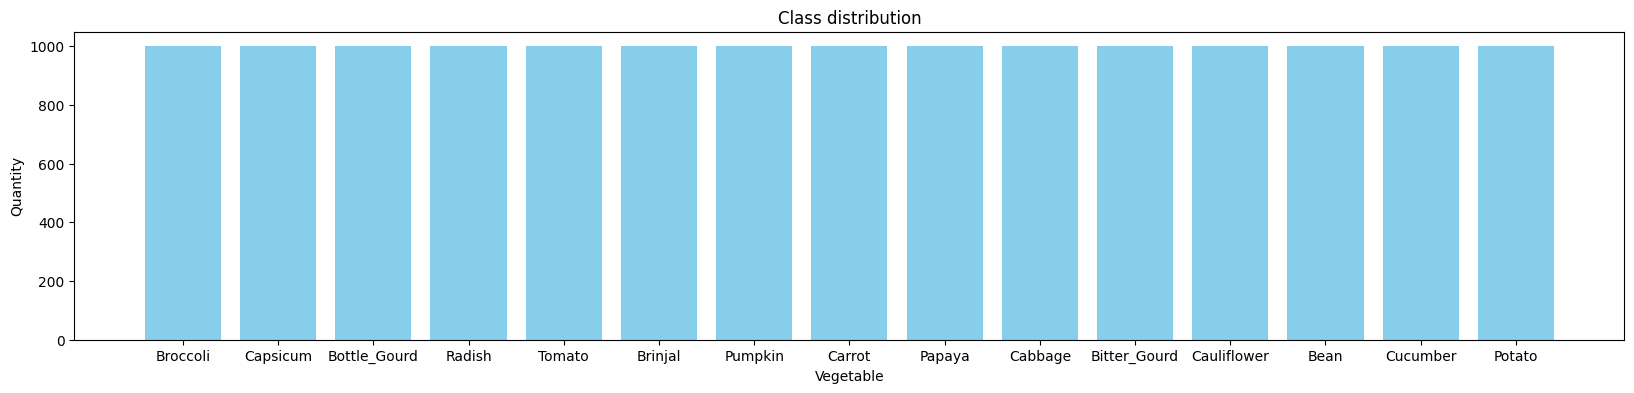

In [ ]:
count_dict = {}

for root, dirs, files in os.walk(train_dir):
    clase = os.path.basename(root)
    count_dict[clase] = len(files)

lables = list(count_dict.keys())[1:]
count = list(count_dict.values())[1:]
plt.figure(figsize=(20,4))
plt.bar(lables, count, color="skyblue")
plt.title("Class distribution")
plt.xlabel("Vegetable")
plt.ylabel("Quantity")
plt.show()

# 4. Loading Data, Data Augmentation and Preprocessing

*   **Loading Data**: We use ImageDataGenerator to load the data because the dataset consists of 15,000 images, which is not too large. This tool is simple to use and efficient for datasets of this size, allowing for easy management and integration into the training pipeline.

*   **Data Augmentation**: Augmentation is applied only to the training set, using techniques such as random rotations, horizontal flips, zooming, shearing, and shifts. The chosen parameters apply mild transformations to the images. Data augmentation helps simulate variations in the dataset and prevents overfitting by making the model more robust to minor changes in the input images.

*   **Preprocessing**: Preprocessing is applied to the entire dataset. All pixel values are rescaled to the range [0, 1] to standardize the input and ensure compatibility with the model

In [ ]:
# Parameters for MobileNet
image_size = 224  # Recommended input size for MobileNet
batch_size = 32   # Batch size for training and validation

# Data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Rescale pixel values to [0, 1]
    rotation_range=20,          # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,      # Random horizontal shift
    height_shift_range=0.2,     # Random vertical shift
    shear_range=0.2,            # Apply shear transformations
    zoom_range=0.2,             # Random zoom on images
    horizontal_flip=True,       # Flip images horizontally
    fill_mode='nearest'         # Fill in missing pixels using 'nearest' method
)

# Rescaling for the validation and test sets (no augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Training data generator with data augmentation
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),  # Resize images to 224x224
    batch_size=batch_size,                # Batch size for training
    class_mode='categorical',             # Multiclass classification
    color_mode='rgb'                      # Ensure images are in RGB format
)

# Validation data generator (no augmentation)
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(image_size, image_size),  # Resize images to 224x224
    batch_size=batch_size,                # Batch size for validation
    class_mode='categorical',             # Multiclass classification
    color_mode='rgb'                      # Ensure images are in RGB format
)

# Test data generator (no augmentation, no shuffling)
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),  # Resize images to 224x224
    batch_size=batch_size,                # Batch size for testing
    class_mode='categorical',             # Multiclass classification
    color_mode='rgb',                     # Ensure images are in RGB format
    shuffle=False                         # Do not shuffle test data for reproducibility
)

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


# 5. Model

## 5.1. Building Model. Fine-tuning

*   **General Approach:**
We build a classification model using deep learning and transfer learning. This approach was chosen for its simplicity, computational efficiency, and the ability to leverage the knowledge gained from pre-trained models on large datasets like ImageNet. Fine-tuning, which involves unfreezing and retraining the last layers of the backbone, is also applied to improve the final results.

*   **Top Model:**
Since our dataset is similar to the ImageNet domain, transfer learning allows us to avoid using a complex top model. Instead, we add only two additional layers to customize the model for our specific task.

*   **Backbone:**
We can select from popular architectures such as ResNet50, VGG16, MobileNetV2, DenseNet121, and InceptionV3. In this example, I chose MobileNetV2 because, while it may not have the highest accuracy according to rankings, it is fast and suitable for testing and experimentation.

*   **Regularization:**
To prevent overfitting, we apply light regularization using Dropout and L2 regularization. These techniques help the model generalize better and avoid memorizing the training data.

In [ ]:
def create_backbone_classification_model(backbone='MobileNetV2', n_layers_to_unfreeze=0):
    # Input layer with shape (224, 224, 3) for image classification
    inputs = Input(shape=(224, 224, 3))

    # Create the backbone model according to the selected architecture
    if backbone == 'ResNet50':
        # Load the ResNet50 model pre-trained on ImageNet, excluding the top layer
        base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)
    elif backbone == 'VGG16':
        # Load the VGG16 model pre-trained on ImageNet, excluding the top layer
        base_model = VGG16(weights='imagenet', include_top=False, input_tensor=inputs)
    elif backbone == 'MobileNetV2':
        # Load the MobileNetV2 model pre-trained on ImageNet, excluding the top layer
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=inputs)
    elif backbone == 'DenseNet121':
        # Load the DenseNet121 model pre-trained on ImageNet, excluding the top layer
        base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=inputs)
    elif backbone == 'InceptionV3':
        # Load the InceptionV3 model pre-trained on ImageNet, excluding the top layer
        base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=inputs)
    else:
        # Raise an error if an unsupported backbone is selected
        raise ValueError(f"Backbone {backbone} is not supported.")

    # Adjust n_layers_to_unfreeze to ensure it's within the valid range (max layers of the backbone)
    n_layers_to_unfreeze = min(n_layers_to_unfreeze, len(base_model.layers))

    # Freeze all layers in the backbone by default
    for layer in base_model.layers:
        layer.trainable = False

    # Unfreeze the last n layers if n_layers_to_unfreeze > 0
    if n_layers_to_unfreeze > 0:
        for layer in base_model.layers[-n_layers_to_unfreeze:]:
            layer.trainable = True

    # Connect the backbone to the rest of the model
    x = base_model.output
    # Apply Global Average Pooling to flatten the output from the backbone
    x = GlobalAveragePooling2D()(x)

    x = Dense(64, kernel_regularizer=regularizers.l2(0.0001), activation='relu')(x)
    # Apply Batch Normalization to improve training stability
    x = BatchNormalization()(x)
    # Add Dropout to prevent overfitting
    x = Dropout(0.1)(x)

    # Add the output layer with 15 classes and softmax activation for multi-class classification
    target_output = Dense(15, activation='softmax')(x)

    # Create and return the final model
    model = Model(inputs=inputs, outputs=target_output)

    return model


## 5.2. Callbacks: EarlyStopping & ReduceLROnPlateau

We use the EarlyStopping callback to prevent overfitting and the ReduceLROnPlateau callback to dynamically adjust the learning rate when the validation loss stops improving

In [ ]:
# EarlyStopping callback to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',           # Monitor validation loss to detect overfitting
    patience=5,                   # Stop training after 5 epochs with no improvement
    restore_best_weights=True     # Restore model weights from the epoch with the lowest validation loss
)

# ReduceLROnPlateau callback to adjust the learning rate dynamically
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',           # Monitor validation loss
    factor=0.2,                   # Reduce learning rate by a factor of 0.2 (20% of current value)
    patience=2,                   # Wait for 2 epochs with no improvement before reducing the learning rate
    min_lr=1e-6                   # Set a lower bound for the learning rate to avoid it becoming too small
)

## 5.3 Model Training and Evaluation

*   **General Approach:**
In this section, we define functions to plot the learning rate and train the model. We use the **Adam** optimizer with a learning rate of 0.001, along with callbacks such as **EarlyStopping** and **ReduceLROnPlateau** to prevent overfitting. The number of epochs is set to 10, as this is a relatively simple task, and based on the learning rates, 10 epochs were sufficient for the model to converge.

*   **Training Results:**
The model successfully trained, and the learning curves indicate convergence. The following performance metrics were achieved at the end of 10 epochs:

*   Training Accuracy: 0.9961
*   Validation Accuracy: 0.9983
*   Training AUROC: 0.9999
*   Validation AUROC: 0.9998
*   Training Loss: 0.0318
*   Validation Loss: 0.0218
*   Training Precision: 0.9962
*   Validation Precision: 0.9987
*   Training Recall: 0.9957
*   Validation Recall: 0.9983

These results indicate that the model achieved near-perfect performance, with excellent accuracy, AUROC, precision, and recall on both the training and validation sets. This suggests that the model is well-calibrated and successfully generalizes to unseen data.

Defining function to plot the learning curves for loss and accuracy during training.

In [ ]:
def plot_learning_curves(history):
    """
    Plots the learning curves for loss and accuracy during training.

    Args:
        history: The history object containing training and validation loss and accuracy.
    """
    # Plot loss and accuracy curves
    plt.figure(figsize=(12, 4))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.ylim(0, 1)  # Set the y-axis range for accuracy from 0 to 1

    # Display the plots
    plt.show()

Definig function to train the model

In [ ]:
def train_model(model,
                train_generator,
                val_generator,
                epochs,
                learning_rate,
                callbacks=None):
    """
    Compiles and trains a model.

    Args:
        model: The model to train.
        train_generator: The training data generator.
        val_generator: The validation data generator.
        epochs (int): Number of epochs to train for.
        learning_rate (float): Learning rate for the optimizer.
        callbacks (list): List of callbacks for training.
    """
    # Compile the model with Adam optimizer and binary crossentropy loss for classification
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=[
                      'accuracy',
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      tf.keras.metrics.AUC(name='auroc')
                  ])

    # Train the model using the provided data generators
    history = model.fit(train_generator,
                        epochs=epochs,
                        validation_data=val_generator,
                        #steps_per_epoch=1,   #for debugging
                        #validation_steps=1,  #for debugging
                        callbacks=callbacks)

    # Convert the history dictionary to a pandas DataFrame
    history_df = pd.DataFrame(history.history)

    # Plot learning curves for training and validation loss and accuracy
    plot_learning_curves(history_df)

In [ ]:
model = create_backbone_classification_model('MobileNetV2',2)
#model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734419944.002157     117 service.cc:145] XLA service 0x7f507c002e80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734419944.002229     117 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734419944.002234     117 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/469 ━━━━━━━━━━━━━━━━━━━━ 2:22:18 18s/step - accuracy: 0.0625 - auroc: 0.4508 - loss: 3.6891 - precision: 0.0000e+00 - recall: 0.0000e+00

I0000 00:00:1734419952.656009     117 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


469/469 ━━━━━━━━━━━━━━━━━━━━ 284s 568ms/step - accuracy: 0.8625 - auroc: 0.9787 - loss: 0.5353 - precision: 0.9441 - recall: 0.7871 - val_accuracy: 0.9893 - val_auroc: 0.9998 - val_loss: 0.0564 - val_precision: 0.9900 - val_recall: 0.9883 - learning_rate: 0.0010
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 176s 369ms/step - accuracy: 0.9868 - auroc: 0.9997 - loss: 0.0714 - precision: 0.9899 - recall: 0.9835 - val_accuracy: 0.9950 - val_auroc: 0.9998 - val_loss: 0.0346 - val_precision: 0.9957 - val_recall: 0.9943 - learning_rate: 0.0010
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 175s 367ms/step - accuracy: 0.9925 - auroc: 0.9999 - loss: 0.0458 - precision: 0.9948 - recall: 0.9911 - val_accuracy: 0.9980 - val_auroc: 0.9996 - val_loss: 0.0283 - val_precision: 0.9983 - val_recall: 0.9967 - learning_rate: 0.0010
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 172s 361ms/step - accuracy: 0.9921 - auroc: 0.9999 - loss: 0.0416 - precision: 0.9931 - recall: 0.9909 - val_accuracy: 0.9983 - val_auroc: 1.0000 - v

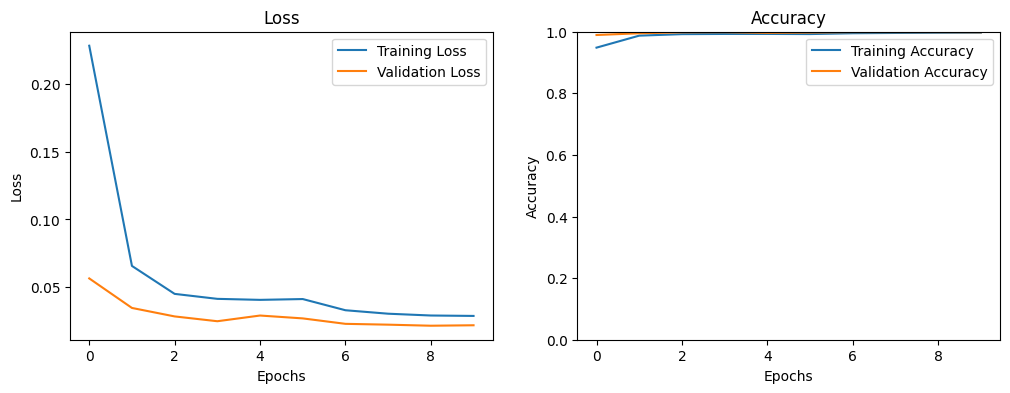

In [ ]:
train_model(model,
            train_generator,  # Preprocessed training dataset
            val_generator,    # Validation dataset
            epochs=10,      # Number of epochs
            learning_rate=0.001,  # Learning rate
            callbacks=[early_stopping, reduce_lr])  # List of callbacks (e.g., early stopping, reduce learning rate)

# 6. Inference and Evaluation

*   **General Approach:**
In this section, we evaluate the model’s performance on unseen test data. Predictions are made using the trained model, and the results are assessed through a classification report and confusion matrix. The objective is to assess how well the model generalizes to new, unseen images.

*   **Evaluation Results:**
The model performs exceptionally well on the test set. The classification report reveals high performance across all metrics, with the following key evaluation results:

*   Accuracy: 0.9998
*   AUROC: 0.9999
*   Loss: 0.0194
*   Precision: 0.9998
*   Recall: 0.9998
  
The confusion matrix confirms that only 3 out of 3,000 test images were misclassified, demonstrating the model’s robustness and its ability to make accurate predictions on unseen data.

## 6.1 Predictions on Test Data

Predictions are made on previously unseen data (test set) using the trained model.

In [ ]:
# Get the true classes (ground truth) from the test generator
true_classes = test_generator.classes

# Predict probabilities for each class using the model
predictions = model.predict(test_generator)

# Convert probabilities to predicted class indices (select the class with the highest probability)
predicted_classes = np.argmax(predictions, axis=1)

test_labels=test_generator.class_indices.keys()

94/94 ━━━━━━━━━━━━━━━━━━━━ 25s 242ms/step


## 6.2 Classification Report

The classification report shows a very high level of average accuracy, along with detailed metrics for each class, including precision, recall, and F1-score, all of which demonstrate strong model performance on the unseen test data.

In [ ]:
model.evaluate(test_generator)

94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.9998 - auroc: 0.9999 - loss: 0.0194 - precision: 0.9998 - recall: 0.9998


[0.02181173488497734,
 0.9990000128746033,
 0.9990000128746033,
 0.9990000128746033,
 0.9998326301574707]

In [ ]:
# Generate the classification report
# target_names assigns human-readable class names from the test generator
report = classification_report(true_classes, predicted_classes, target_names=test_labels)
print(report)


              precision    recall  f1-score   support

        Bean       1.00      1.00      1.00       200
Bitter_Gourd       1.00      1.00      1.00       200
Bottle_Gourd       1.00      1.00      1.00       200
     Brinjal       1.00      1.00      1.00       200
    Broccoli       1.00      1.00      1.00       200
     Cabbage       1.00      1.00      1.00       200
    Capsicum       1.00      1.00      1.00       200
      Carrot       1.00      1.00      1.00       200
 Cauliflower       1.00      1.00      1.00       200
    Cucumber       1.00      1.00      1.00       200
      Papaya       1.00      0.99      1.00       200
      Potato       1.00      1.00      1.00       200
     Pumpkin       1.00      1.00      1.00       200
      Radish       1.00      0.99      1.00       200
      Tomato       0.99      0.99      0.99       200

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00   

## 6.3 Confusion Matrix

The confusion matrix reveals that only 3 images out of 3000 were misclassified. This suggests that the model is performing exceptionally well, with very few errors.

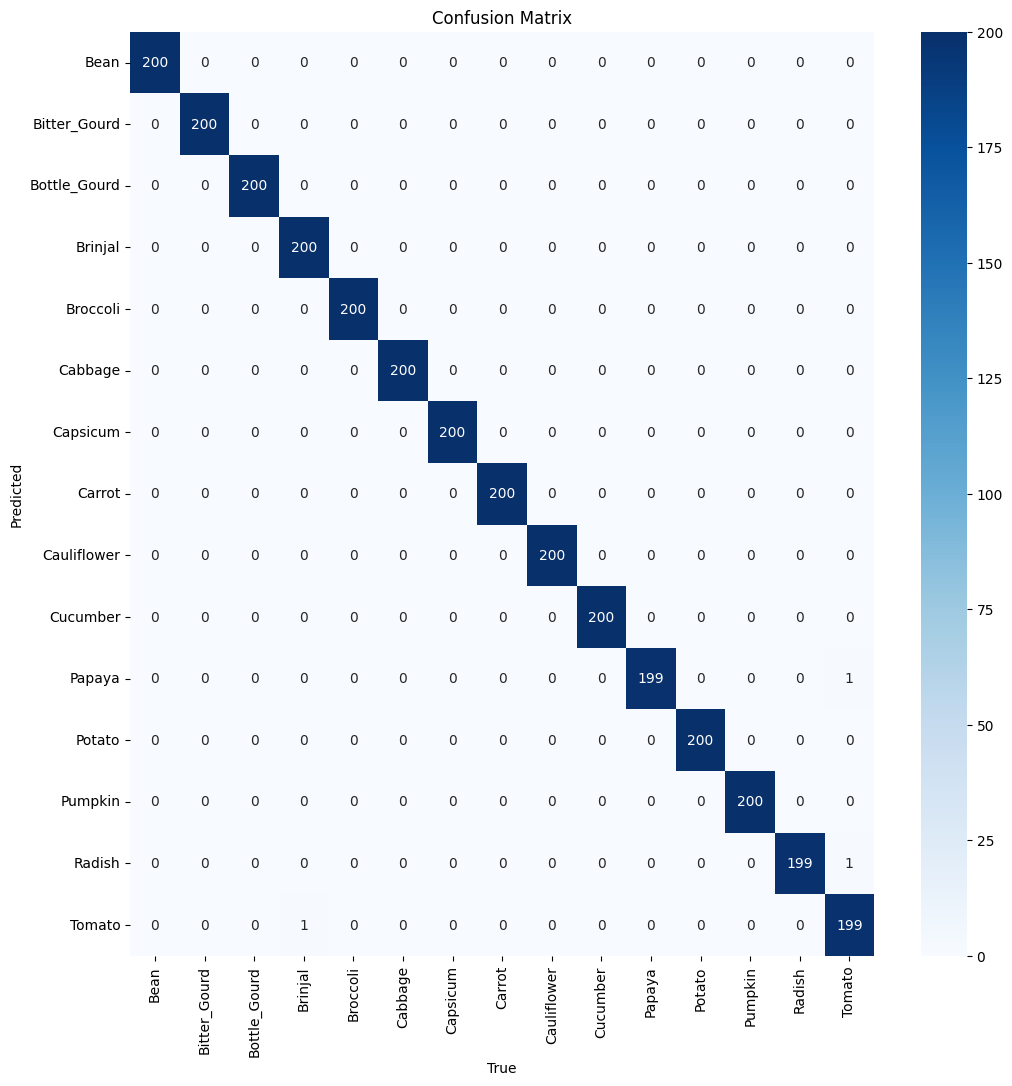

In [ ]:
plt.figure(figsize=(12,12))
cm=confusion_matrix(true_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d',cmap="Blues", xticklabels=test_labels,yticklabels=test_labels)
plt.title("Confusion Matrix")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

## 6.4. Misclassified Examples

Upon review, the misclassifications are mostly related to the "motato" class. However, the error rate is very low, so no further investigation is necessary at this point.

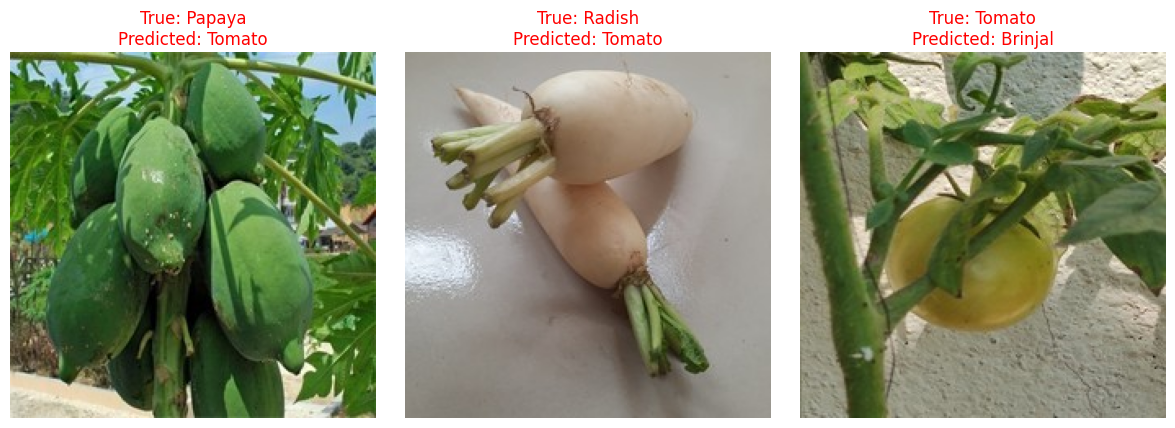

In [ ]:
# Get indices of misclassified examples (limit to the first 9)
misclassified_indices = np.nonzero(true_classes != predicted_classes)[0][:9]

# Get file paths and class labels
images_paths = test_generator.filepaths
test_labels = list(test_generator.class_indices.keys())  # Convert keys to a list

# Create the plot
plt.figure(figsize=(12, 12))
for i, idx in enumerate(misclassified_indices):
    img_path = images_paths[idx]
    img = plt.imread(img_path)  # Load the image

    # Get true and predicted labels
    true_label = test_labels[true_classes[idx]]
    predicted_label = test_labels[predicted_classes[idx]]

    # Plot the image
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPredicted: {predicted_label}", color="red")
    plt.axis('off')  # Turn off axes for better visualization

plt.tight_layout()
plt.show()


P.S. **Thank you for exploring this notebook!**